## Main Test

In [1]:
# import necessary libraries
import os, sys, glob
import math
import time
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torchvision import transforms


from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from PIL import Image
from importlib import reload # when you make changes to a .py, force reload imports


# custom imports
sys.path.append('../')

from utils.GetLowestGPU import GetLowestGPU
from utils.GetLR import get_lr
import utils.Train as Train
import utils.Plot as Plot


import data_setup
import model_builder
# import utils.WeightedCrossEntropy as WeightedCrossEntropy
# import utils.BuildUNet as BuildUNet
# import utils.TileGenerator as TG
# import utils.DistanceMap as DistanceMap

device = torch.device(GetLowestGPU(verbose=2))

/home/h6x/miniconda3/envs/pytorch_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


---------------------------
 GPU | Memory-usage    
---------------------------
  0  | 00014MiB / 40537MiB
  1  | 00004MiB / 40537MiB
---------------------------
 Device set to cuda:1
---------------------------


In [2]:
# Setup directories

root_dir = "/home/h6x/git_projects/ornl-svi-data-processing/experiment_2/processed_data_1/npy_combined"
annotation_file_path ="/home/h6x/git_projects/ornl-svi-data-processing/experiment_2/processed_data_1/annotations_2018_npy_2_classes_only_h0h1_90_percentile.csv"


In [3]:
# Setup target device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Create transforms
data_transform = transforms.Compose([
  transforms.ToTensor()
])


In [4]:
BATCH_SIZE = 32 # why not include in penny????????? 
CONFIG_NAME = 50

In [5]:
# Create DataLoaders with help from data_setup.py
train_dataloader, validation_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    annotation_file_path=annotation_file_path,
    root_dir=root_dir,
    transform=data_transform,
    batch_size=BATCH_SIZE
)

In [6]:
model = model_builder.SEResNet(CONFIG_NAME).to(device)

In [7]:
# Set loss and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.RMSprop(model.parameters(),
#                              lr=LEARNING_RATE)
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)

In [8]:
# not needed
model_kwargs = {
    'layer_sizes': [32, 64, 128, 256, 512],
    'in_channels': 3,
    'out_channels': 4,
    'conv_per_block': 3,
    'dropout_rate': 0.1,
    'hidden_activation': torch.nn.SELU(),
    'output_activation': None
}


In [9]:
train_idx = []
val_idx = []

In [10]:
reload(Train)

# log options
log_path = '../logs/log.csv'
chckpnt_path = '../checkpoints/checkpoint_{0}.pt'

# lr options
warmup_iters = 1000
lr_decay_iters = 90000
max_lr = 1e-3
min_lr = 1e-5
max_iters = 150000

Train.train_model(model = model,
                  loss_function = loss_fn,
                  optimizer = optimizer,
                  train_generator = train_dataloader,
                  val_generator = validation_dataloader,
                  log_path = log_path,
                  chckpnt_path = chckpnt_path,
                  model_kwargs = model_kwargs,
                  train_idx = train_idx,
                  val_idx = val_idx,
                  device = device,
                  warmup_iters = 1000,
                  lr_decay_iters = 90000,
                  max_lr = 1e-3,
                  min_lr = 1e-5,
                  max_iters = 150000
                  )


---------------------------------------
Iteration: 767 | Best Loss: 1.1852e-03
---------------------------------------


 Eval:   0%|          | 3/1000 [00:02<12:27,  1.33it/s]


train loss 9.0647e-05, val loss 3.2381e-03
validation has not improved in 51 steps

*** no improvement for 50 steps, stopping ***


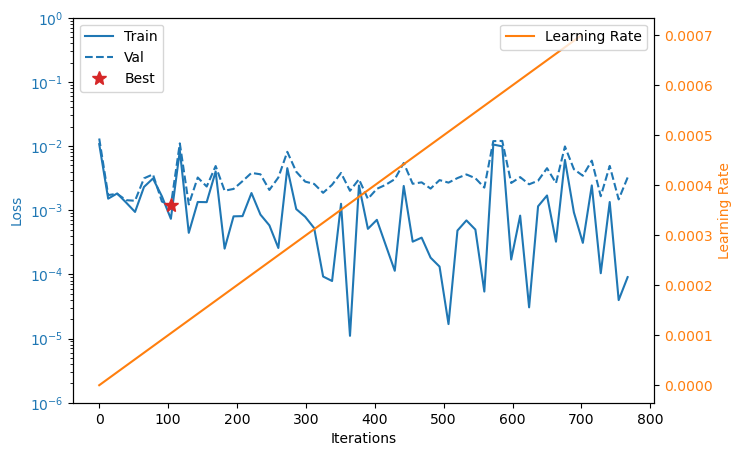

: 

In [11]:
reload(Plot)
Plot.plot_loss(log_path='../logs/log.csv',
               warmup_iters=warmup_iters,
               lr_decay_iters=90000,
               max_lr=max_lr,
               min_lr=min_lr)